# FakeNewsNetCNN

This notebook builds and evaluates Convolutional Neural Network (CNN) model for detecting fake news using the FakeNewsNet dataset, that contians two subsets, GossipCop and PolitiFact. This work is based on the work of Shu et al. [7] and Denny Britz repository. [11]

## Import necessary libraries

In [4]:
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Check and install keras-tuner if not available
try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner
    import keras_tuner as kt

## Add Reproducibility logic


Functions to set seeds and preserve deterministic operations are defined for reproducibility. Different runs have the same results.

In [5]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Ensure deterministic operations
def set_deterministic():
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

# Call set_deterministic before any TensorFlow operations
set_deterministic()

## Load Preprocessed Data from Google Drive


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the preprocessed datasets from Google Drive
gossipcop_combined = pd.read_csv('/content/drive/My Drive/gossipcop_preprocessed.csv')
politifact_combined = pd.read_csv('/content/drive/My Drive/politifact_preprocessed.csv')

# Quick check of the data loaded
print(gossipcop_combined.head())
print(politifact_combined.head())

Mounted at /content/drive
                                               title  label
0  lea michel hairstylist mix textur spray coconu...      1
1  thoma markl princ harri polit miss daughter me...      0
2  2019 sag award nomin see full list nomine varieti      1
3  see meghan markl royal coat arm symbol hide wi...      1
4    kyli jenner visit shaman life kyli season final      1
                                               title  label
0         world popular candi remov shelv octob 2017      0
1                             brows congression bill      1
2                          suprem court vacanc video      1
3                                    u import export      1
4  die 78 year old cia agent admit kill marilyn m...      0


## Check loaded data

In [7]:
# Check for NaN values in datasets
print("NaN values in GossipCop dataset:\n", gossipcop_combined.isnull().sum())
print("NaN values in PolitiFact dataset:\n", politifact_combined.isnull().sum())

# Ensure there are no NaN values
gossipcop_combined.dropna(inplace=True)
politifact_combined.dropna(inplace=True)

# Re-check for NaN values in datasets
print("NaN values in GossipCop dataset after dropna:\n", gossipcop_combined.isnull().sum())
print("NaN values in PolitiFact dataset after dropna:\n", politifact_combined.isnull().sum())

NaN values in GossipCop dataset:
 title    1
label    0
dtype: int64
NaN values in PolitiFact dataset:
 title    2
label    0
dtype: int64
NaN values in GossipCop dataset after dropna:
 title    0
label    0
dtype: int64
NaN values in PolitiFact dataset after dropna:
 title    0
label    0
dtype: int64


##  Prepare Data for CNN

Features (X) and labels (y) are defined for both datasets. Text data is tokenized, padded, and split into training and testing sets. Tokenization converts text into numerical values. This process makes it suitable for neural network operations. Padding keeps uniform input length and enables efficient batch processing as explained by Denny Britz blog post linked to his repository[11]. Encoding labels into numerical form standardizes the output for classification tasks. I am splitting the dataset the same way as Shu et al. [7]: "We use 80% of data for training and 20% for testing."

In [8]:
# Define features (X) and labels (y)
X_gossipcop = gossipcop_combined['title'].values
y_gossipcop = gossipcop_combined['label'].values
X_politifact = politifact_combined['title'].values
y_politifact = politifact_combined['label'].values

# Function to tokenize and pad sequences
def tokenize_and_pad(texts, max_num_words=5000, maxlen=100):
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
    return padded_sequences, tokenizer

# Tokenize and pad the sequences for both datasets
X_gossipcop, tokenizer_gossipcop = tokenize_and_pad(X_gossipcop)
X_politifact, tokenizer_politifact = tokenize_and_pad(X_politifact)

# Encode the labels as integers
def encode_labels(labels):
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    return encoded_labels, le

y_gossipcop, le_gossipcop = encode_labels(y_gossipcop)
y_politifact, le_politifact = encode_labels(y_politifact)

# Split the data into training and testing sets for both datasets with a test size of 20%
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train_gossipcop, X_test_gossipcop, y_train_gossipcop, y_test_gossipcop = split_data(X_gossipcop, y_gossipcop)
X_train_politifact, X_test_politifact, y_train_politifact, y_test_politifact = split_data(X_politifact, y_politifact)

## Build the CNN Model

Separate CNN models for GossipCop and PolitiFact are built using embedding, convolutional, pooling, dropout, and dense layers. Models are compiled with Adam optimizer and binary crossentropy loss. I have experimented with different layers, parameters and settings explained by Denny Britz [11].

In [9]:
# Build the CNN Model for GossipCop
def create_cnn_model_gossipcop(input_length):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=input_length),  # Embedding layer
        Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Conv1D layer
        MaxPooling1D(pool_size=2),  # MaxPooling layer
        Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Conv1D layer
        GlobalMaxPooling1D(),  # GlobalMaxPooling layer
        Dense(units=32, activation='relu'),  # Dense layer
        Dropout(0.5),  # Dropout layer
        Dense(units=1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the CNN Model for PolitiFact
def create_cnn_model_politifact(input_length):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=input_length),  # Embedding layer
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Conv1D layer
        MaxPooling1D(pool_size=2),  # MaxPooling layer
        Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Conv1D layer
        GlobalMaxPooling1D(),  # GlobalMaxPooling layer
        Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)),  # Dense layer
        Dropout(0.6),  # Dropout layer
        Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_length = X_train_gossipcop.shape[1]

cnn_model_gossipcop = create_cnn_model_gossipcop(input_length)
cnn_model_politifact = create_cnn_model_politifact(input_length)

# Callbacks to prevent overfitting and make training more efficient
early_stopping_gossipcop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Stop training when a monitored metric has stopped improving
early_stopping_politifact = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001) # Reduce the learning rate when a metric has stopped improving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Handle Class Imbalance

Class weights are calculated to handle class imbalance in the datasets. These weights are used during model training to balance the impact of each class.

In [10]:
# Function to compute class weights and return as a dictionary
def compute_class_weights(y_train):
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

# Calculate class weights for GossipCop
class_weights_dict_gossipcop = compute_class_weights(y_train_gossipcop)

# Calculate class weights for PolitiFact
class_weights_dict_politifact = compute_class_weights(y_train_politifact)

## Train and Evaluate CNN Model

The CNN models are trained with early stopping and learning rate reduction callbacks. Performance metrics accuracy, precision, recall, F1-score, and ROC AUC are calculated and displayed, also with confusion matrices and ROC curves.

According to Powers et al.[16], “The F1-score, which is the harmonic mean of precision and recall, is particularly recommended for imbalanced datasets because it provides a balance between false positives and false negatives, thus giving a more comprehensive measure of a model's performance.” so I will use F1 score during training and evaluation.

Keras doesn't natively support the F1 score as a metric during training. I will keep accuracy as a metric for monitoring during training because it's fast and gives a general sense of model performance. I will use a custom callback to log the F1 score at the end of each epoch.

In [11]:
# Custom callback to log the F1 score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        val_true = self.validation_data[1]
        val_f1 = f1_score(val_true, val_pred)
        val_precision = precision_score(val_true, val_pred)
        val_recall = recall_score(val_true, val_pred)
        self.f1_scores.append(val_f1)
        self.precision_scores.append(val_precision)
        self.recall_scores.append(val_recall)
        print(f' — val_f1: {val_f1:.4f} — val_precision: {val_precision:.4f} — val_recall: {val_recall:.4f}')

In [12]:
# Train and evaluate the model, returning the model, predictions and history
def train_and_evaluate(model, X_train, X_test, y_train, y_test, class_weights, early_stopping, reduce_lr, train_model=True):
    f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))
    history = None

    if train_model:
        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                            validation_split=0.2, class_weight=class_weights, verbose=1,
                            callbacks=[early_stopping, reduce_lr, f1_callback])
        # Update history to include F1, precision, and recall
        history.history['val_f1_score'] = f1_callback.f1_scores
        history.history['val_precision'] = f1_callback.precision_scores
        history.history['val_recall'] = f1_callback.recall_scores

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Print and plot evaluation metrics and figures
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return model, y_pred, history

### Model Training and Evaluation

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 — val_f1: 0.8683 — val_precision: 0.7683 — val_recall: 0.9982
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.4799 - loss: 1.7763 - val_accuracy: 0.7671 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 — val_f1: 0.8825 — val_precision: 0.7996 — val_recall: 0.9847
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6306 - loss: 1.2043 - val_accuracy: 0.8013 - val_loss: 0.9562 - learning_rate: 1.0000e-04
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 — val_f1: 0.8891 — val_precision: 0.8578 — val_recall: 0.9227
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7706 - loss: 0.9178 - val_accuracy: 0.8236 - val_loss: 0.7375 - learning_rate: 1.0000e-04
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 — val_f1: 0.8701 — val_precision: 0.9047 — val_recall: 0.8380
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8028 - loss: 0.7131 - val_accuracy: 0.7959

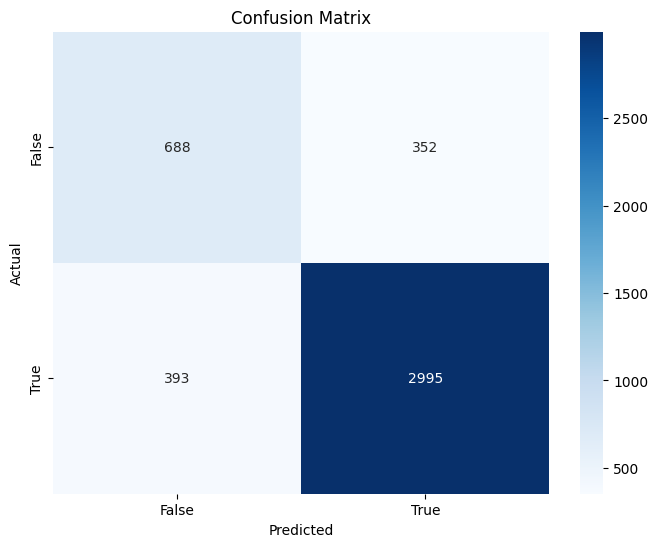

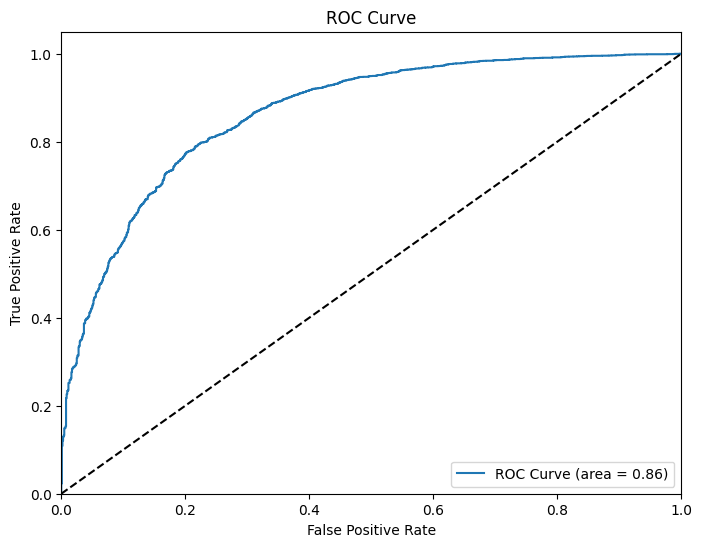

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 — val_f1: 0.5520 — val_precision: 0.6703 — val_recall: 0.4692
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.5199 - loss: 3.4466 - val_accuracy: 0.5503 - val_loss: 3.3734 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 — val_f1: 0.4894 — val_precision: 0.7931 — val_recall: 0.3538
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5408 - loss: 3.3440 - val_accuracy: 0.5740 - val_loss: 3.2736 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 — val_f1: 0.3636 — val_precision: 0.8571 — val_recall: 0.2308
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.5131 - loss: 3.2449 - val_accuracy: 0.4911 - val_loss: 3.1774 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 — val_f1: 0.3860 — val_precision: 0.8049 — val_recall: 0.2538
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5551 - loss: 3.1478 - val_accuracy: 0.5089 - val_loss: 3.0846 

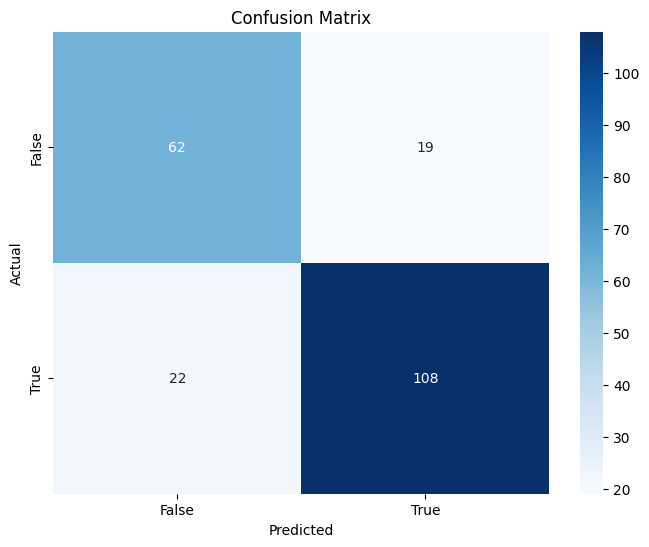

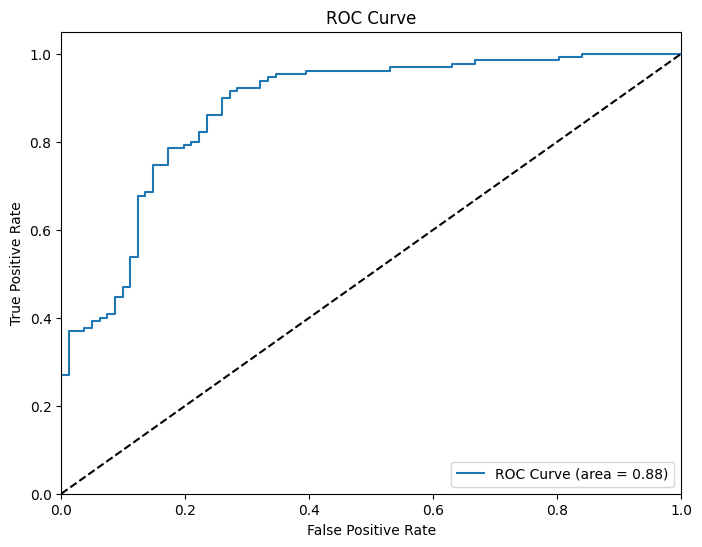

In [13]:
# Train and evaluate the CNN model for GossipCop dataset
cnn_model_gossipcop, y_pred_gossipcop, history_gossipcop = train_and_evaluate(cnn_model_gossipcop, X_train_gossipcop, X_test_gossipcop, y_train_gossipcop, y_test_gossipcop, class_weights_dict_gossipcop, early_stopping_gossipcop, reduce_lr, train_model=True)

# Train and evaluate the CNN model for PolitiFact dataset
cnn_model_politifact, y_pred_politifact, history_politifact = train_and_evaluate(cnn_model_politifact, X_train_politifact, X_test_politifact, y_train_politifact, y_test_politifact, class_weights_dict_politifact, early_stopping_politifact, reduce_lr, train_model=True)

### Model Performance over Epochs

The training history including F1 Score and loss for both training and validation sets is plotted for each dataset.



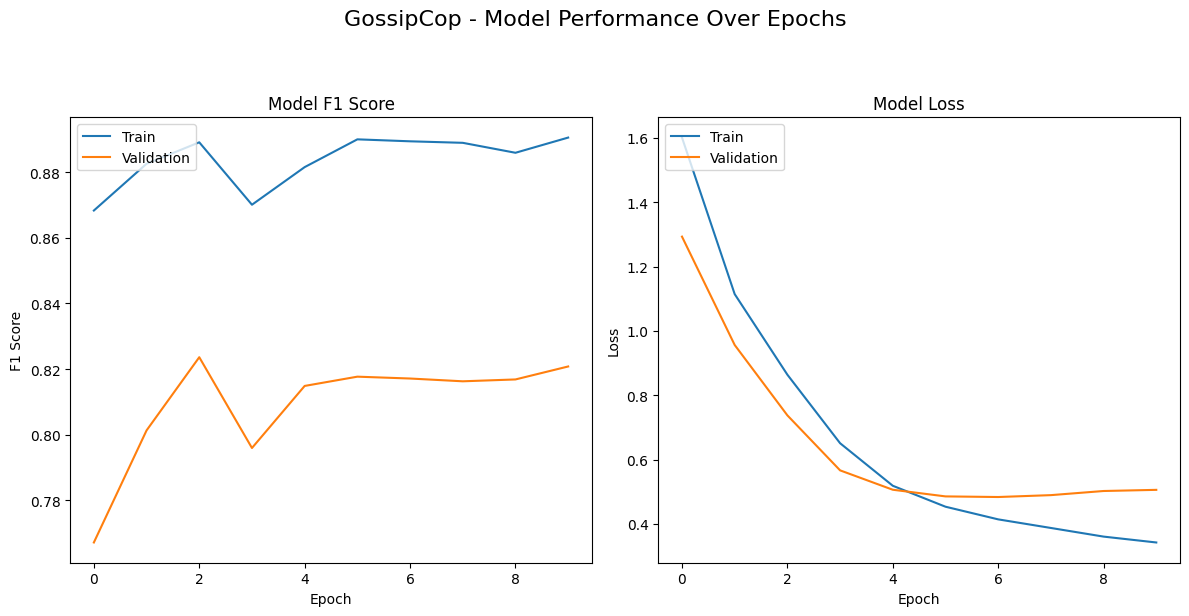

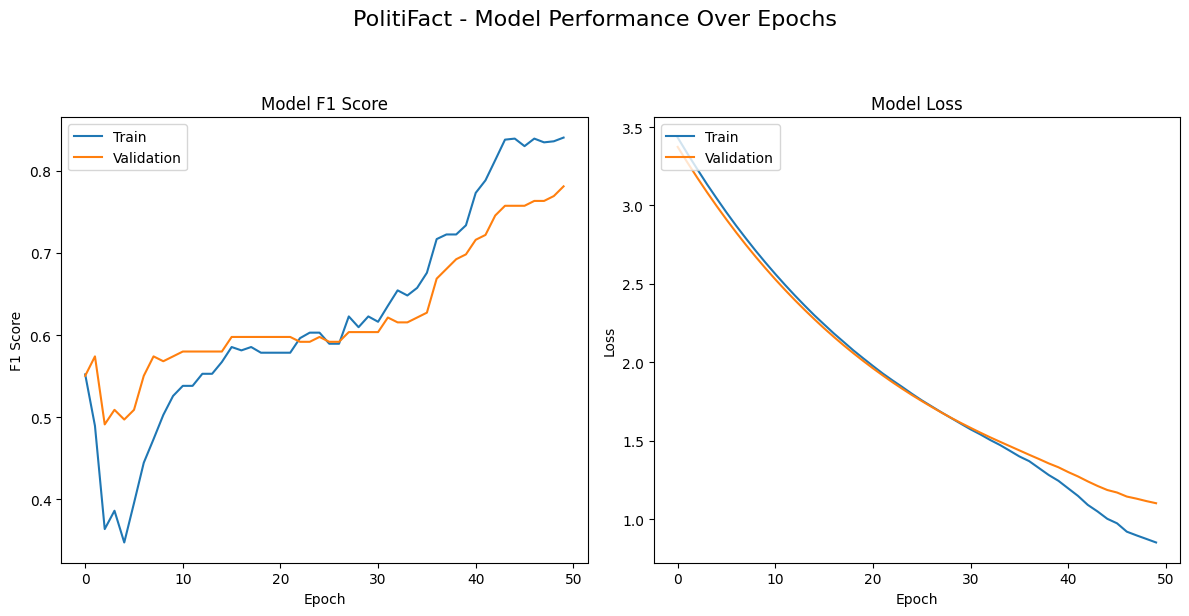

In [14]:
def plot_training_history(history, dataset_name):
    # Plot training & validation F1 score values
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{dataset_name} - Model Performance Over Epochs', fontsize=16, y=1.02)  # y parameter for spacing

    plt.subplot(1, 2, 1)
    if 'val_f1_score' in history.history:
        plt.plot(history.history['val_f1_score'])
        plt.title('Model F1 Score')
        plt.ylabel('F1 Score')
    else:
        plt.plot(history.history['accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot training history for GossipCop
plot_training_history(history_gossipcop, "GossipCop")

# Plot training history for PolitiFact
plot_training_history(history_politifact, "PolitiFact")

F1 score graphs show an increase over the epochs. It means the models are learning and improving their ability to balance precision and recall.

The loss graphs show a steady decrease in both training and validation loss at the beginning, that stabilizes towards the later epochs. This means the models are converging and learning effectively without overfitting.

### Comparison of my results with baseline Shu et al. [7]

Shu et al. Baseline Results:

    GossipCop
        Accuracy: 0.723
        Precision: 0.751
        Recall: 0.701
        F1: 0.725
        
    PolitiFact
        Accuracy: 0.629
        Precision: 0.807
        Recall: 0.456
        F1: 0.583

My Model Results:

    GossipCop
        Accuracy: 0.8318
        Precision: 0.8948
        Recall: 0.8840
        F1: 0.8894

    PolitiFact
        Accuracy: 0.8057
        Precision: 0.8504
        Recall: 0.8308
        F1: 0.8405


My models significantly outperformed Shu et al.'s CNN results in all metrics for both datasets.


## Implement 5-Fold Cross-Validation

I will randomly split the datasets into five parts and conduct 5-fold cross-validation to obtain robust results, as Bian et al.[5] did. Cross-validation is a statistical method used to estimate the performance of machine learning models. As Browne et al.[15] explain: “In its simplest form, the leaving one out at a time method, this involves partitioning a sample of size N into a calibration sample of size N-1 and a validation sample of size 1 and repeating the process N times. An average of the N cross-validation index values is then used.” This method involves splitting the data into a number of subsets (folds), training the model on some subsets while testing it on the remaining subset, and repeating this process several times. The performance metrics are then averaged over all iterations to provide a more robust evaluation.

### Cross-Validation Function

I could not use scikeras for k-fold cross validation due to compatibility issues with existing models, so I implemented k-fold cross validation manually.

In [15]:
# Function to perform cross-validation
def run_kfold_cross_validation(X_data, y_data, create_model_func, dataset_name, n_splits=5):
    X = np.array(X_data)
    y = np.array(y_data)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1

    # Initialize lists to store fold-wise performance metrics
    f1_scores, precision_scores, recall_scores = [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Clearing the TensorFlow backend to prevent data leakage
        clear_session()

        # Create a new instance of the CNN model
        model = create_model_func(input_length)

        # Train the model
        print(f'Training for fold {fold_no} on {dataset_name}...')
        model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

        # Evaluate the model
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)

        # Calculate metrics
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

        print(f'Fold {fold_no} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

        fold_no += 1

    # Return the average scores
    print(f'Average Precision: {np.mean(precision_scores):.4f}')
    print(f'Average Recall: {np.mean(recall_scores):.4f}')
    print(f'Average F1 Score: {np.mean(f1_scores):.4f}')

### Cross-Validation Scores

In [16]:
# Run cross-validation
run_kfold_cross_validation(X_gossipcop, y_gossipcop, create_cnn_model_gossipcop, "GossipCop")
run_kfold_cross_validation(X_politifact, y_politifact, create_cnn_model_politifact, "PolitiFact")

Training for fold 1 on GossipCop...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7266 - loss: 1.6738 - val_accuracy: 0.7651 - val_loss: 1.0707
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.7560 - loss: 0.9933 - val_accuracy: 0.7651 - val_loss: 0.7552
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.7560 - loss: 0.7377 - val_accuracy: 0.7651 - val_loss: 0.6311
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7560 - loss: 0.6369 - val_accuracy: 0.7651 - val_loss: 0.5842
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.7560 - loss: 0.5990 - val_accuracy: 0.7651 - val_loss: 0.5660
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7560 - loss: 0.5845 - val_accuracy: 0.7651 - val_loss: 0.5587
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7560 - loss: 0.5756 - val_accuracy: 0.7651 - val_loss: 0.5547
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.7560 - loss: 0.5718 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.6808 - loss: 1.6950 - val_accuracy: 0.7565 - val_loss: 1.0686
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 43s 82ms/step - accuracy: 0.7576 - loss: 0.9791 - val_accuracy: 0.7565 - val_loss: 0.7532
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.7576 - loss: 0.7269 - val_accuracy: 0.7565 - val_loss: 0.6334
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.7576 - loss: 0.6298 - val_accuracy: 0.7565 - val_loss: 0.5893
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.7576 - loss: 0.5950 - val_accuracy: 0.7565 - val_loss: 0.5732
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7576 - loss: 0.5815 - val_accuracy: 0.7565 - val_loss: 0.5667
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7576 - loss: 0.5756 - val_accuracy: 0.7565 - val_loss: 0.5639
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7576 - loss: 0.5712 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.6654 - loss: 1.6911 - val_accuracy: 0.7545 - val_loss: 1.0713
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.7603 - loss: 0.9795 - val_accuracy: 0.7545 - val_loss: 0.7577
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.7603 - loss: 0.7262 - val_accuracy: 0.7545 - val_loss: 0.6378
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7603 - loss: 0.6296 - val_accuracy: 0.7545 - val_loss: 0.5931
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.7603 - loss: 0.5911 - val_accuracy: 0.7545 - val_loss: 0.5763
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.7603 - loss: 0.5769 - val_accuracy: 0.7545 - val_loss: 0.5694
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7603 - loss: 0.5744 - val_accuracy: 0.7545 - val_loss: 0.5664
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.7603 - loss: 0.5694 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.6056 - loss: 1.7161 - val_accuracy: 0.7642 - val_loss: 1.0730
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7587 - loss: 0.9947 - val_accuracy: 0.7642 - val_loss: 0.7518
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7587 - loss: 0.7374 - val_accuracy: 0.7642 - val_loss: 0.6294
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.7587 - loss: 0.6346 - val_accuracy: 0.7642 - val_loss: 0.5842
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.7587 - loss: 0.5963 - val_accuracy: 0.7642 - val_loss: 0.5672
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.7587 - loss: 0.5834 - val_accuracy: 0.7642 - val_loss: 0.5590
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.7587 - loss: 0.5773 - val_accuracy: 0.7642 - val_loss: 0.5568
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7587 - loss: 0.5733 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.7521 - loss: 1.6654 - val_accuracy: 0.7574 - val_loss: 1.0783
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.7600 - loss: 0.9843 - val_accuracy: 0.7574 - val_loss: 0.7640
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.7600 - loss: 0.7298 - val_accuracy: 0.7574 - val_loss: 0.6398
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.7600 - loss: 0.6332 - val_accuracy: 0.7574 - val_loss: 0.5928
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.7600 - loss: 0.5925 - val_accuracy: 0.7574 - val_loss: 0.5743
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7600 - loss: 0.5766 - val_accuracy: 0.7574 - val_loss: 0.5626
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.7612 - loss: 0.5553 - val_accuracy: 0.7990 - val_loss: 0.4870
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.8111 - loss: 0.4608 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.5793 - loss: 3.4624 - val_accuracy: 0.6161 - val_loss: 3.3594
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5982 - loss: 3.3315 - val_accuracy: 0.6161 - val_loss: 3.2334
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5910 - loss: 3.2054 - val_accuracy: 0.6161 - val_loss: 3.1132
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5936 - loss: 3.0865 - val_accuracy: 0.6161 - val_loss: 2.9989
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5896 - loss: 2.9759 - val_accuracy: 0.6161 - val_loss: 2.8906
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5880 - loss: 2.8654 - val_accuracy: 0.6161 - val_loss: 2.7875
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.5869 - loss: 2.7640 - val_accuracy: 0.6161 - val_loss: 2.6897
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5874 - loss: 2.6670 - val_accuracy: 0.6161 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.5861 - loss: 3.4623 - val_accuracy: 0.6066 - val_loss: 3.3619
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.5967 - loss: 3.3321 - val_accuracy: 0.6066 - val_loss: 3.2362
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5877 - loss: 3.2075 - val_accuracy: 0.6066 - val_loss: 3.1163
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5822 - loss: 3.0897 - val_accuracy: 0.6066 - val_loss: 3.0020
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5840 - loss: 2.9763 - val_accuracy: 0.6066 - val_loss: 2.8932
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5892 - loss: 2.8688 - val_accuracy: 0.6066 - val_loss: 2.7898
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5844 - loss: 2.7663 - val_accuracy: 0.6066 - val_loss: 2.6915
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5841 - loss: 2.6685 - val_accuracy: 0.6066 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold 2 - Precision: 0.8976, Recall: 0.8906, F1 Score: 0.8941
Training for fold 3 on PolitiFact...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5788 - loss: 3.4714 - val_accuracy: 0.5640 - val_loss: 3.3727
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6267 - loss: 3.3393 - val_accuracy: 0.5640 - val_loss: 3.2472
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.6010 - loss: 3.2146 - val_accuracy: 0.5640 - val_loss: 3.1274
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.6072 - loss: 3.0934 - val_accuracy: 0.5640 - val_loss: 3.0132
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.6119 - loss: 2.9814 - val_accuracy: 0.5640 - val_loss: 2.9048
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6073 - loss: 2.8725 - val_accuracy: 0.5640 - val_loss: 2.8017
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.6055 - loss: 2.7701 - val_accuracy: 0.5640 - val_loss: 2.7038
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.6060 - loss: 2.6749 - val_accuracy: 0.5640 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Fold 3 - Precision: 0.8293, Recall: 0.8571, F1 Score: 0.8430
Training for fold 4 on PolitiFact...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5130 - loss: 3.4579 - val_accuracy: 0.5687 - val_loss: 3.3594
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5385 - loss: 3.3281 - val_accuracy: 0.5782 - val_loss: 3.2340
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5679 - loss: 3.2035 - val_accuracy: 0.5782 - val_loss: 3.1142
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.6048 - loss: 3.0829 - val_accuracy: 0.5782 - val_loss: 2.9997
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6016 - loss: 2.9689 - val_accuracy: 0.5782 - val_loss: 2.8907
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6038 - loss: 2.8629 - val_accuracy: 0.5782 - val_loss: 2.7872
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.5966 - loss: 2.7609 - val_accuracy: 0.5782 - val_loss: 2.6890
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5976 - loss: 2.6615 - val_accuracy: 0.5782 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.5680 - loss: 3.4520 - val_accuracy: 0.5857 - val_loss: 3.3528
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5995 - loss: 3.3196 - val_accuracy: 0.5857 - val_loss: 3.2278
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6112 - loss: 3.1962 - val_accuracy: 0.5857 - val_loss: 3.1090
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6152 - loss: 3.0774 - val_accuracy: 0.5857 - val_loss: 2.9966
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6066 - loss: 2.9667 - val_accuracy: 0.5857 - val_loss: 2.8898
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6172 - loss: 2.8593 - val_accuracy: 0.5857 - val_loss: 2.7881
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6086 - loss: 2.7582 - val_accuracy: 0.5857 - val_loss: 2.6914
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.6123 - loss: 2.6621 - val_accuracy: 0.5857 - val_

The metrics across different folds show stable performance for both datasets:

GossipCop

    Fold 1 - Precision: 0.8644, Recall: 0.9141, F1 Score: 0.8885
    Fold 2 - Precision: 0.8703, Recall: 0.9051, F1 Score: 0.8873
    Fold 3 - Precision: 0.7545, Recall: 1.0000, F1 Score: 0.8601
    Fold 4 - Precision: 0.7642, Recall: 1.0000, F1 Score: 0.8664
    Fold 5 - Precision: 0.8675, Recall: 0.8867, F1 Score: 0.8770
    
    Average Precision: 0.8242
    Average Recall: 0.9412
    Average F1 Score: 0.8759
    
PolitiFact

    Fold 1 - Precision: 0.8472, Recall: 0.9385, F1 Score: 0.8905
    Fold 2 - Precision: 0.8976, Recall: 0.8906, F1 Score: 0.8941
    Fold 3 - Precision: 0.8293, Recall: 0.8571, F1 Score: 0.8430
    Fold 4 - Precision: 0.8769, Recall: 0.9344, F1 Score: 0.9048
    Fold 5 - Precision: 0.8908, Recall: 0.8618, F1 Score: 0.8760
    
    Average Precision: 0.8648
    Average Recall: 0.8965
    Average F1 Score: 0.8817


## Hyperparameter Tuning

I have selected Keras tuner for my CNN hyperparameter tuning. Keras Tuner demonstrates superior accuracy in CNN applications (see Table II in Halim et al.[18]).

### Hyperparameter Tuning Functions

In [17]:
# This class defines a hypermodel for hyperparameter tuning with Keras Tuner
# It accepts hyperparameters to tune and inherits from kt.HyperModel and allows integration with the Keras Tuner library
class CNNHyperModel(kt.HyperModel):
    def __init__(self, input_dim, max_len):
        # Initialize the hypermodel with the maximum vocabulary size and the maximum length of input sequences
        self.input_dim = input_dim
        self.max_len = max_len

    def build(self, hp):
        # Build the model architecture with hyperparameters that will be tuned.
        # This method is called by the tuner to create new models with different hyperparameter values
        model = Sequential([
            # Embedding layer to transform indices into dense vectors of fixed size
            Embedding(input_dim=self.input_dim, output_dim=128, input_length=self.max_len),
            # Conv1D layer with hyperparameters for number of filters and kernel size that will be tuned
            Conv1D(
                filters=hp.Choice('filters', [32, 64, 128]),
                kernel_size=hp.Choice('kernel_size', [3, 5]),
                activation='relu',
                kernel_regularizer=l2(0.01)  # L2 regularization to prevent overfitting.
            ),
            MaxPooling1D(pool_size=2),  # MaxPooling to reduce the spatial dimensions
            GlobalMaxPooling1D(),  # Global max pooling to reduce the output of the convolutional layer to a single vector
            Dense(
                units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                activation='relu'
            ),
            Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),  # Dropout layer to prevent overfitting
            Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
        ])
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(curve='PR')]  # Use Precision-Recall AUC as a metric for imbalanced classification
        )
        return model

# This function configures and executes the hyperparameter tuning using Keras Tuner
# It sets up the tuner, defines the hypermodel, and manages the training process
# Function includes callbacks for early stopping and learning rate reduction
def tune_model(X_train, y_train, X_test, y_test, input_dim, max_len, n_trials, directory, project_name):
    # Setup the hypermodel instance with provided input dimension and maximum length
    hypermodel = CNNHyperModel(input_dim=input_dim, max_len=max_len)

    # Configure the tuner with RandomSearch algorithm, focus on maximizing the AUC
    tuner = kt.RandomSearch(
        hypermodel,
        objective=kt.Objective("val_auc", direction="max"),
        max_trials=n_trials,
        executions_per_trial=1,
        directory=directory,
        project_name=project_name
    )

    # Validation data used by tuner
    val_data = (X_test, y_test)
    # Use existing F1 score callback for additional performance metric tracking
    f1_callback = F1ScoreCallback(validation_data=val_data)

    # Start hyperparameter search process, use early stopping and learning rate reduction to optimize training
    tuner.search(
        x=X_train,
        y=y_train,
        epochs=50,
        validation_data=val_data,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001),
                   f1_callback]
    )

    # Get the best model after the search
    best_model = tuner.get_best_models(num_models=1)[0]
    return tuner, best_model  # Return the tuner and the best model

### Hyperparameter Tuning Results

In [18]:
# Run hyperparameter tuning for each dataset
tuner_gossipcop, best_model_gossipcop = tune_model(
    X_train_gossipcop, y_train_gossipcop, X_test_gossipcop, y_test_gossipcop,
    5000, 100, 10, 'hyper_tuning_gossipcop', 'GossipCopTuning'
)

tuner_politifact, best_model_politifact = tune_model(
    X_train_politifact, y_train_politifact, X_test_politifact, y_test_politifact,
    5000, 100, 10, 'hyper_tuning_politifact', 'PolitiFactTuning'
)

Trial 10 Complete [00h 00m 16s]
val_auc: 0.9387391209602356

Best val_auc So Far: 0.9391252994537354
Total elapsed time: 00h 06m 14s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
# This function displays the best hyperparameters found by the tuner for a specific dataset
def display_best_hyperparameters_and_summary(tuner, dataset_name):
    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters()[0]
    print(f"Best hyperparameters for {dataset_name}:")
    print(f"  Best filter size: {best_hps.get('filters')}")
    print(f"  Best kernel size: {best_hps.get('kernel_size')}")
    print(f"  Best dense units: {best_hps.get('dense_units')}")
    print(f"  Best learning rate: {best_hps.get('learning_rate')}\n")

    # Get the best model and print the model summary
    best_model = tuner.get_best_models(num_models=1)[0]
    print(f"Model summary for {dataset_name}:")
    best_model.summary()

# GossipCop tuning results
display_best_hyperparameters_and_summary(tuner_gossipcop, "GossipCop")

# Politifact tuning results
display_best_hyperparameters_and_summary(tuner_politifact, "PolitiFact")

Best hyperparameters for GossipCop:
  Best filter size: 32
  Best kernel size: 5
  Best dense units: 32
  Best learning rate: 0.0001655876301640272

Model summary for GossipCop:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 661,601 (2.52 MB)

 Trainable params: 661,601 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters for PolitiFact:
  Best filter size: 32
  Best kernel size: 5
  Best dense units: 64
  Best learning rate: 0.0011563133814945622

Model summary for PolitiFact:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,689 (2.53 MB)

 Trainable params: 662,689 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.8525
Precision: 0.8821
Recall: 0.9318
F1-score: 0.9063
ROC AUC: 0.8722
Confusion Matrix:
[[ 618  422]
 [ 231 3157]]


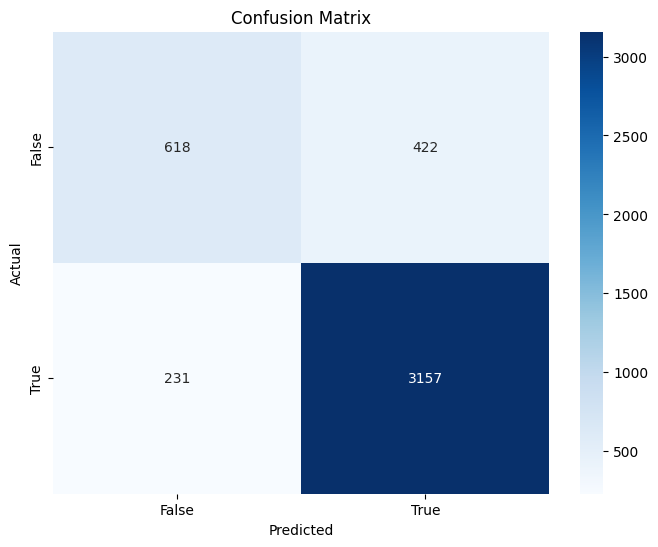

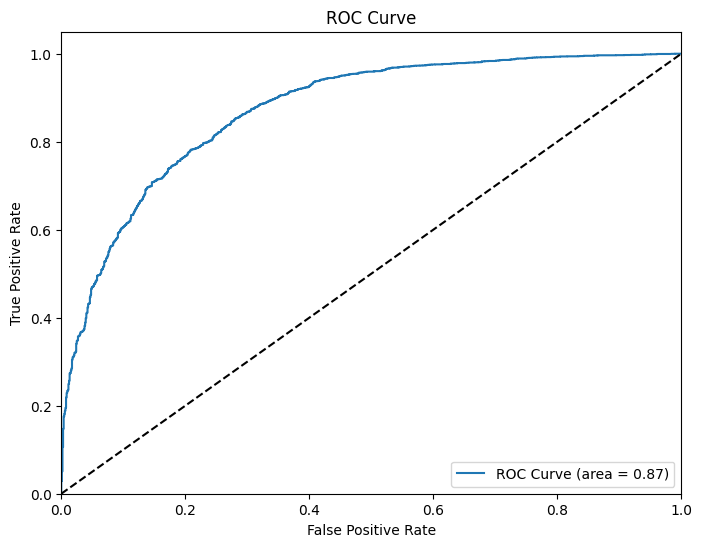

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.8246
Precision: 0.8252
Recall: 0.9077
F1-score: 0.8645
ROC AUC: 0.9066
Confusion Matrix:
[[ 56  25]
 [ 12 118]]


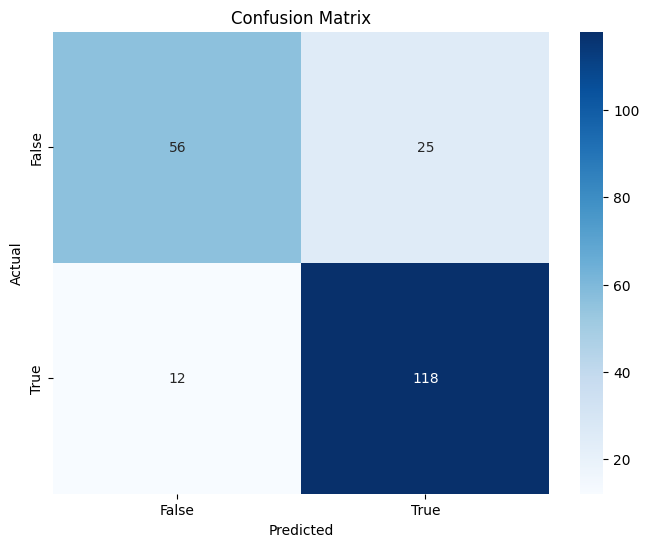

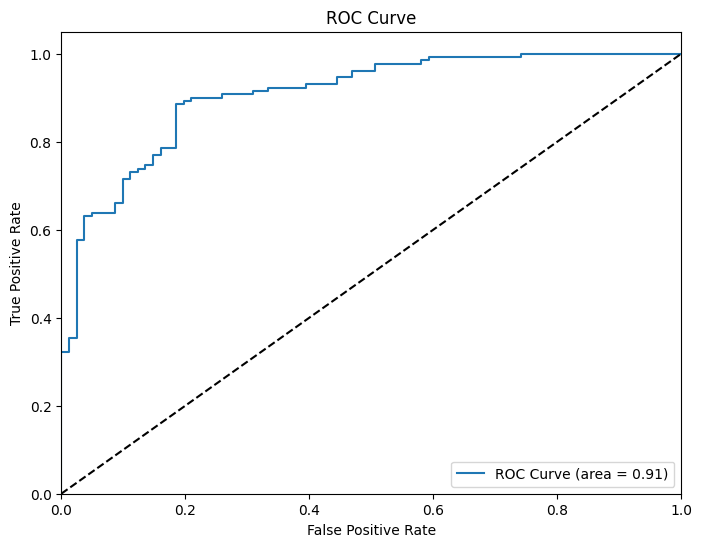

In [20]:
# Evaluate the tuned model for GossipCop dataset
_, y_pred_gossipcop_tuned, _ = train_and_evaluate(best_model_gossipcop, None, X_test_gossipcop, None, y_test_gossipcop, None, None, None, train_model=False)

# Evaluate the tuned model for PolitiFact dataset
_, y_pred_politifact_tuned, _ = train_and_evaluate(best_model_politifact, None, X_test_politifact, None, y_test_politifact, None, None, None, train_model=False)

GossipCop Dataset

Initial Model Results:

    Accuracy: 0.8318
    Precision: 0.8948
    Recall: 0.8840
    F1-score: 0.8894
    ROC AUC: 0.8648

Tuned Model Results:

    Accuracy: 0.8525
    Precision: 0.8821
    Recall: 0.9318
    F1-score: 0.9063
    ROC AUC: 0.8722

Accuracy and ROC AUC show improvements in the tuned model, with better performance.
Recall is higher, which means that it is better at identifying actual positive (fake news) instances.
Precision has decreased, so the tuned model has a higher rate of false positives.
F1-score is higher.

PolitiFact Dataset

Initial Model Results:

    Accuracy: 0.8057
    Precision: 0.8504
    Recall: 0.8308
    F1-score: 0.8405
    ROC AUC: 0.8760

Tuned Model Results:

    Accuracy: 0.8246
    Precision: 0.8252
    Recall: 0.9077
    F1-score: 0.8645
    ROC AUC: 0.9066

Accuracy has increased in the tuned model, this means it is more effective as the initial model.
Precision is lower, but recall has increased, this means the tuned model misses more actual positive cases.
F1-score is higher and corresponds to the increase in recall.
ROC AUC has improved despite the lower accuracy.


For the GossipCop dataset, the tuned model has improved in most metrics, so this is my preferred model.

For the PolitiFact dataset, the results are mixed. Because of this, I choose the original model and not the tuned model.

## Save the Best Models to Google Drive

In [21]:
# Save the best tuned model for GossipCop
best_model_gossipcop = tuner_gossipcop.get_best_models(num_models=1)[0]
model_filename_gossipcop = '/content/drive/My Drive/best_cnn_model_gossipcop.keras'
best_model_gossipcop.save(model_filename_gossipcop)
print("Best CNN model for GossipCop saved to Google Drive")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best CNN model for GossipCop saved to Google Drive


In [22]:
# Save the GossipCop tokenizer and label encoder
joblib.dump(tokenizer_gossipcop, '/content/drive/My Drive/tokenizer_gossipcop.pkl')
joblib.dump(le_gossipcop, '/content/drive/My Drive/label_encoder_gossipcop.pkl')
print("GossipCop tokenizer and label encoder saved to Google Drive")

GossipCop tokenizer and label encoder saved to Google Drive


In [23]:
# Save the best untuned model for PolitiFact
model_filename_politifact = '/content/drive/My Drive/best_cnn_model_politifact.keras'
cnn_model_politifact.save(model_filename_politifact)
print("Best CNN model for PolitiFact saved to Google Drive")

Best CNN model for PolitiFact saved to Google Drive


In [24]:
# Save the PolitiFact tokenizer and label encoder
joblib.dump(tokenizer_politifact, '/content/drive/My Drive/tokenizer_politifact.pkl')
joblib.dump(le_politifact, '/content/drive/My Drive/label_encoder_politifact.pkl')
print("PolitiFact tokenizer and label encoder saved to Google Drive")

PolitiFact tokenizer and label encoder saved to Google Drive


## Conclusion

My models significantly outperform the baseline results across all metrics for both datasets (GossipCop and PolitiFact). Calculated class weights in both datasets handle class imbalance. Hyperparameter tuning improved GosspiCop model performance, which was not the case for PolitiFact model. The best performing model was GossipCop with tuned hyperparameters.

## References

[7] SHU, K., MAHUDESWARAN, D., WANG, S., LEE, D., and LIU, H. 2018. FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media. https://doi.org/10.48550/arXiv.1809.01286

[11] BRITZ, D. 2021. Convolutional Neural Network for Text Classification in TensorFlow. https://github.com/dennybritz/cnn-text-classification-tf

[15] BROWNE, M.W. 2000. Cross-Validation Methods. Journal of Mathematical Psychology, 44, 108–132. https://doi.org/10.1006/jmps.1999.1279

[16] POWERS, D.M.W. 2011. Evaluation: From Precision, Recall and F-measure to ROC, Informedness, Markedness and Correlation. International Journal of Machine Learning Technology, 2(1), pp. 37-63. https://doi.org/10.48550/arXiv.2010.16061

[18] HALIM, A., CHOW, C., BUDIHARTO, M., ACHMAD, S., and SUTOYO, R. 2023. The Impact of Hyperparameter Tuning in Convolutional Neural Network on Image Classification Model: A Case Study of Plant Disease Detection. In Proceedings of the IEEE Conference on Innovative Research and Development (ICORIS), pp. 1-6. https://doi.org/10.1109/ICORIS60118.2023.10352209

In [25]:
# Install LaTeX packages necessary for converting notebooks to PDF
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic texlive-latex-extra pandoc

# Convert the notebook to PDF
!jupyter nbconvert --to pdf "/content/drive/My Drive/Colab Notebooks/FakeNewsNetCNN.ipynb"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [976 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,287 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,499 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,569 kB]
Get:14